# Fuzzy Product Quantization Experiments

Importing libraries:

In [1]:
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from search_approaches import PQ, FuzzyPQ, IVF, ExactSearch, FuzzyIVF
from utils import *
np.warnings = warnings

This PQ implementation leverages Fuzzy C-Means to compute the centroids of the subspaces. It encodes the indices of the two centroids with the highest membership values, along with their corresponding membership ratio ($r=\frac{m_2}{m_1}$, where $m_1$ denotes the highest membership probability and $m_2$ the second highest membership probability). Distances are then calculated in each subspace as a weighted average of the distances between these centroids and the query, using the membership probabilities as weights (recovered from $r$ as follows: $m_1=\frac{1}{1+r}, m_2=\frac{r}{1+r}$).

We used the Fuzzy CMeans implementation from the [scikit-fda](https://fda.readthedocs.io/en/latest/) library.

In [2]:
help(FuzzyPQ)

Help on class FuzzyPQ in module search_approaches:

class FuzzyPQ(PQ)
 |  FuzzyPQ(M: int = 8, K: int = 256, kmeans_iter: int = 300, fuzzifier: float = 2, seed: int = None, orth_transf: bool = False, dim_reduction: bool = False)
 |  
 |  Fuzzy Product Quantization implementation.
 |  
 |  Method resolution order:
 |      FuzzyPQ
 |      PQ
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, M: int = 8, K: int = 256, kmeans_iter: int = 300, fuzzifier: float = 2, seed: int = None, orth_transf: bool = False, dim_reduction: bool = False)
 |      Constructor.
 |      
 |      Parameters
 |      ----------
 |      
 |      M : int, default=8
 |          Number of subspaces.
 |      
 |      K : int, default=256
 |          Number of clusters per subspace.
 |      
 |      kmeans_iter : int, default=300
 |          Maximum number of iterations for Fuzzy KMeans.
 |      
 |      fuzzifier : float, default=2
 |          Hyper-parameter that controls how fuzzy the clust

Defining constants:

In [3]:
RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)
DATASET = "siftsmall" # "glove"
DIR = "siftsmall" # "glove"
SEARCH_TRAIN_SUBSET = False # True if vectors to search in are a subset of the training set
tab10 = matplotlib.colormaps["tab10"]

Loading the data.

NOTE: GloVe embeddings are normalized to have unit norm, ensuring that the squared Euclidean distance is proportional to cosine similarity (commonly used for comparing word embeddings), differing only by a constant factor.

In [4]:
tr_data, search_data, queries, gt = load_data(
    dataset_name=DATASET,
    dataset_dir=DIR,
    search_train_subset=SEARCH_TRAIN_SUBSET,
    random_seed=RANDOM_SEED
)

sample_query = queries[0]
sample_query_snorm = np.sum(np.square(sample_query))
print("Base vectors (to search in) shape: ", search_data.shape)
print(f"Base vectors (to search in) range: [{search_data.min()}, {search_data.max()}]")
print("Query vectors shape: ", queries.shape)
if DATASET == "siftsmall":
    print("Ground truth shape: ", gt.shape)
print("Learn vectors shape: ", tr_data.shape)
print("Query example:\n", queries[0])

Base vectors (to search in) shape:  (10000, 128)
Base vectors (to search in) range: [0.0, 180.0]
Query vectors shape:  (100, 128)
Ground truth shape:  (100, 100)
Learn vectors shape:  (25000, 128)
Query example:
 [  1.   3.  11. 110.  62.  22.   4.   0.  43.  21.  22.  18.   6.  28.
  64.   9.  11.   1.   0.   0.   1.  40. 101.  21.  20.   2.   4.   2.
   2.   9.  18.  35.   1.   1.   7.  25. 108. 116.  63.   2.   0.   0.
  11.  74.  40. 101. 116.   3.  33.   1.   1.  11.  14.  18. 116. 116.
  68.  12.   5.   4.   2.   2.   9. 102.  17.   3.  10.  18.   8.  15.
  67.  63.  15.   0.  14. 116.  80.   0.   2.  22.  96.  37.  28.  88.
  43.   1.   4.  18. 116.  51.   5.  11.  32.  14.   8.  23.  44.  17.
  12.   9.   0.   0.  19.  37.  85.  18.  16. 104.  22.   6.   2.  26.
  12.  58.  67.  82.  25.  12.   2.   2.  25.  18.   8.   2.  19.  42.
  48.  11.]


Computing the exact ranking:

In [5]:
es = ExactSearch(search_data)
exact_ranks = np.empty((queries.shape[0], search_data.shape[0]))

for i, query in enumerate(queries):
    d, rank = es.search(query)
    exact_ranks[i] = rank

Defining a function to compute the average recall at various values of R for a set of queries. Both the "nearest recall at R" and "recall at R" are computed: the former measures the proportion of query vectors for which the nearest neighbor is ranked in the first R positions, while the latter measures the average recall at R. In the original article, only "nearest recall at R is analyzed, with the authors noting that the conclusions are similar for recall at R.

In [6]:
def compute_recall(index, R, queries, exact_ranks, w=4):
    """
    Compute average recall at all values in R for the given index and queries.

    Parameters
    ----------

    index : PQ, Fuzzy PQ or IVF
        The index to use for the search.
    
    R : list
        The list of values for which to compute the recall at.

    queries : np.ndarray
        The queries to use for the search.

    exact_ranks : np.ndarray
        The exact ranking of the search data for each query.

    w : int
        The number of centroids to visit in the IVF index.

    Returns
    -------

    results : dict
        A dictionary containing the mean recall at each value of R and the
        inertia of the index.
        Recall is computed both as the number of relevant items in the top R,
        and as the presence of the nearest item in the top R (nearest recall).

    """

    recall = np.full((len(queries), len(R)), np.nan)
    nearest_recall = np.full((len(queries), len(R)), np.nan)

    for i, query in enumerate(queries):
        if type(index) == PQ:
            _, rank = index.search(query, subset=None, asym=True, correct=False)
        elif type(index) == FuzzyPQ:
            _, rank = index.search(query, subset=None)
        elif type(index) == IVF:
            _, rank = index.search(query, w=w, asym=True, correct=False)
        elif type(index) == FuzzyIVF:
            _, rank = index.search(query, w=w)

        for j, r in enumerate(R):
            if r <= len(rank):
                recall[i][j] = recall_at_r(rank, exact_ranks[i], r)
                nearest_recall[i][j] = exact_ranks[i][0] in rank[:r]

    # Catch the warning risen when the number of retrieved items for all the
    # queries is smaller than some value of R
    with warnings.catch_warnings(record=True) as w:
        recall_mean = np.nanmean(recall, axis=0)
        nearest_recall_mean = np.nanmean(nearest_recall, axis=0)
        if w:
            for warning in w:
                if "Mean of empty slice" not in str(warning.message):
                    warnings.warn(warning.message, warning.category)

    results = {
        "recall_mean": recall_mean,
        "nearest_recall_mean": nearest_recall_mean,
        "inertia": index.inertia
    }

    return results

Computing the average recall at various values of R for the set of queries with different values of the parameter `fuzzifier` (which determines the degree of fuzziness in Fuzzy C-Means clustering; it must be $>1$, higher values results in fuzzier clusters):

In [7]:
R = [1, 2, 5, 10, 25, 50, 100]
if DATASET == "glove":
    M = 10
elif DATASET == "gift":
    M = 30
else:
    M = 4
K = 256

results_fpq = {}

pq = PQ(M=M, K=K, seed=RANDOM_SEED)
print(f"Training the PQ quantizer with M={M}, K={K}"
    f" (chunk size = {tr_data.shape[1] // M})...")
pq.train(tr_data, add=False, verbose=True)
pq.add(search_data)
results_fpq[None] = compute_recall(pq, R, queries, exact_ranks)
results_fpq[None]["search_NMSE"] = NMSE(search_data, pq.decompress(pq.pqcode))
compressed_tr = pq.compress(tr_data)
results_fpq[None]["train_NMSE"] = NMSE(tr_data, pq.decompress(compressed_tr))
results_fpq[None]["mean_n_iter"] = np.mean(pq.n_iter)
results_fpq[None]["std_n_iter"] = np.std(pq.n_iter)
results_fpq[None]["compression_factor"] = search_data.nbytes / pq.pqcode.nbytes
del pq

memberships = {}
fuzzifiers = [1.1, 1.2, 1.3]
for fuzzifier in fuzzifiers:
    fpq = FuzzyPQ(M=M, K=K, seed=RANDOM_SEED, fuzzifier=fuzzifier, kmeans_iter=400)
    print(f"Training the FuzzyPQ quantizer with M={M}, K={K}, fuzziness={fuzzifier}"
        f" (chunk size = {tr_data.shape[1] // M})...")
    fpq.train(tr_data, add=False, verbose=True)
    fpq.add(search_data)
    memberships[fuzzifier] = fpq.membership_ratio
    results_fpq[fuzzifier] = compute_recall(fpq, R, queries, exact_ranks)
    results_fpq[fuzzifier]["search_NMSE"] = NMSE(search_data, fpq.decompress(fpq.pqcode, fpq.membership_ratio))
    compressed_tr, compressed_tr_membership = fpq.compress(tr_data)
    results_fpq[fuzzifier]["train_NMSE"] = NMSE(tr_data, fpq.decompress(compressed_tr, compressed_tr_membership))
    results_fpq[fuzzifier]["mean_n_iter"] = np.mean(fpq.n_iter)
    results_fpq[fuzzifier]["std_n_iter"] = np.std(fpq.n_iter)
    results_fpq[fuzzifier]["compression_factor"] = search_data.nbytes / (fpq.pqcode.nbytes + fpq.membership_ratio.nbytes)
del fpq

Training the PQ quantizer with M=4, K=256 (chunk size = 32)...
KMeans on subspace 1 converged in 70 iterations with an inertia of 214047600.0.
KMeans on subspace 2 converged in 65 iterations with an inertia of 267283248.0.
KMeans on subspace 3 converged in 73 iterations with an inertia of 266638176.0.
KMeans on subspace 4 converged in 78 iterations with an inertia of 213002464.0.
Training the FuzzyPQ quantizer with M=4, K=256, fuzziness=1.1 (chunk size = 32)...
KMeans on subspace 1 converged in 261 iterations with an inertia of 6026886.181248233.
KMeans on subspace 2 converged in 185 iterations with an inertia of 7585785.23378619.
KMeans on subspace 3 converged in 175 iterations with an inertia of 7537644.376439222.
KMeans on subspace 4 converged in 161 iterations with an inertia of 5982429.385421156.
Training the FuzzyPQ quantizer with M=4, K=256, fuzziness=1.2 (chunk size = 32)...
KMeans on subspace 1 converged in 191 iterations with an inertia of 5070901.938514581.
KMeans on subspac

Displaying the results:

In [8]:
results_fpq_df = pd.DataFrame(results_fpq).T.rename_axis('fuzzifier').reset_index()
results_fpq_df["recall@1"] = results_fpq_df["recall_mean"].apply(lambda x: x[0])
cols_to_show = ['fuzzifier', 'search_NMSE', 'train_NMSE', 'mean_n_iter', 'std_n_iter', 'compression_factor', 'recall@1']
results_fpq_df[cols_to_show].style.background_gradient(cmap='Blues', subset=cols_to_show)

,fuzzifier,search_NMSE,train_NMSE,mean_n_iter,std_n_iter,compression_factor,recall@1
0,nan,0.156562,0.148633,71.500000,4.716991,128.000000,0.320000
1,1.100000,0.138952,0.140396,195.500000,38.765320,32.000000,0.390000
2,1.200000,0.149621,0.150661,177.250000,31.987302,32.000000,0.320000
3,1.300000,0.207431,0.209167,93.500000,37.798810,32.000000,0.230000


Plotting recall at R:

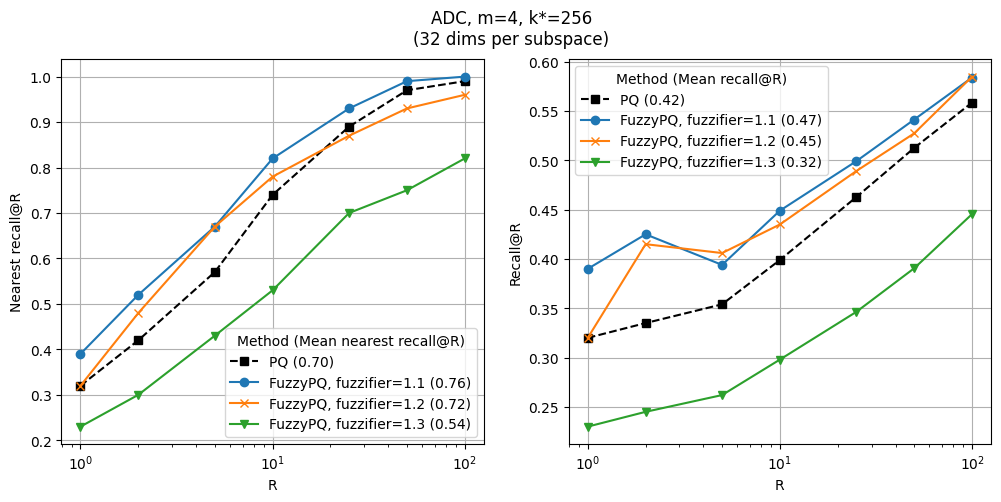

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

markers = ['-o', '-x', '-v']
axs[0].plot(R, results_fpq[None]["nearest_recall_mean"], '--s', label=f"PQ ({np.mean(results_fpq[None]['nearest_recall_mean']):.2f})", color="black")
for i, fuzzifier in enumerate(fuzzifiers):
    axs[0].plot(R, results_fpq[fuzzifier]["nearest_recall_mean"], markers[i], label=f"FuzzyPQ, fuzzifier={fuzzifier} ({np.mean(results_fpq[fuzzifier]['nearest_recall_mean']):.2f})")
axs[0].set_xscale('log')
axs[0].set_xlabel('R')
axs[0].set_ylabel('Nearest recall@R')
axs[0].legend(title="Method (Mean nearest recall@R)")
axs[0].grid()

axs[1].plot(R, results_fpq[None]["recall_mean"], '--s', label=f"PQ ({np.mean(results_fpq[None]['recall_mean']):.2f})", color="black")
for i, fuzzifier in enumerate(fuzzifiers):
    axs[1].plot(R, results_fpq[fuzzifier]["recall_mean"], markers[i], label=f"FuzzyPQ, fuzzifier={fuzzifier} ({np.mean(results_fpq[fuzzifier]['recall_mean']):.2f})")
axs[1].set_xscale('log')
axs[1].set_xlabel('R')
axs[1].set_ylabel('Recall@R')
axs[1].legend(title="Method (Mean recall@R)")
axs[1].grid()

fig.suptitle(f"ADC, m={M}, k*={K}\n({tr_data.shape[1] // M} dims per subspace)");

Visualizing membership probabilities for subspace 0:

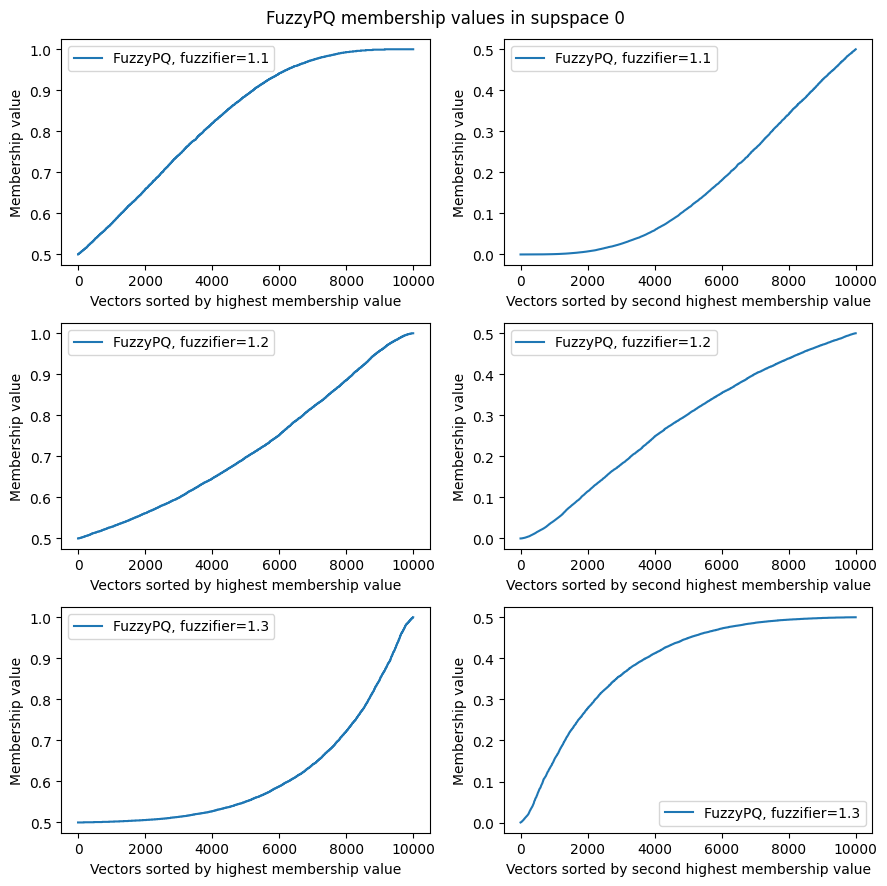

In [10]:
fig, axs = plt.subplots(len(memberships), 2, figsize=(9, 3*len(memberships)))

for idx, (fuzzifier, membership_ratio) in enumerate(memberships.items()):
    membership = np.empty((membership_ratio.shape[0], 2), np.float16)
    membership[:, 0] = 1 / (1 + membership_ratio[:, 0])
    membership[:, 1] = membership_ratio[:, 0] / (1 + membership_ratio[:, 0])
    sorted_membership_0 = np.sort(membership[:, 0])
    sorted_membership_1 = np.sort(membership[:, 1])
    
    axs[idx, 0].plot(range(sorted_membership_0.shape[0]), sorted_membership_0, label=f"FuzzyPQ, fuzzifier={fuzzifier}")
    axs[idx, 0].set_xlabel('Vectors sorted by highest membership value')
    axs[idx, 0].set_ylabel('Membership value')
    axs[idx, 0].legend()
    
    axs[idx, 1].plot(range(sorted_membership_1.shape[0]), sorted_membership_1, label=f"FuzzyPQ, fuzzifier={fuzzifier}")
    axs[idx, 1].set_xlabel('Vectors sorted by second highest membership value')
    axs[idx, 1].set_ylabel('Membership value')
    axs[idx, 1].legend()

plt.suptitle("FuzzyPQ membership values in supspace 0")
plt.tight_layout()
plt.show()

Computing the average recall at various values of R for the set of queries with different values of K and the previously identified best value of `fuzzifier`:

In [11]:
KP = 128
W = 8

ivf = IVF(Kp=KP, M=M, K=K, seed=RANDOM_SEED)
ivf.train(tr_data, add=False, verbose=True)
ivf.add(search_data)
results_ivf = compute_recall(ivf, R, queries, exact_ranks, w=W)

fuzzifier = 1.1
fivf = FuzzyIVF(Kp=KP, M=M, K=K, fuzzifier=fuzzifier, seed=RANDOM_SEED)
fivf.train(tr_data, add=False, verbose=True)
fivf.add(search_data)
results_fivf = compute_recall(fivf, R, queries, exact_ranks, w=W)

Coarse clustering algorithm converged in 61 iterations.
KMeans on subspace 1 converged in 69 iterations with an inertia of 185509216.0.
KMeans on subspace 2 converged in 70 iterations with an inertia of 219355376.0.
KMeans on subspace 3 converged in 50 iterations with an inertia of 218951616.0.
KMeans on subspace 4 converged in 67 iterations with an inertia of 185237024.0.
Coarse clustering algorithm converged in 64 iterations.
KMeans on subspace 1 converged in 300 iterations with an inertia of 5108215.119336291.
KMeans on subspace 2 converged in 300 iterations with an inertia of 5984052.700864363.
KMeans on subspace 3 converged in 300 iterations with an inertia of 5967038.408710043.
KMeans on subspace 4 converged in 300 iterations with an inertia of 5099106.9891002895.


Plotting recall at R:

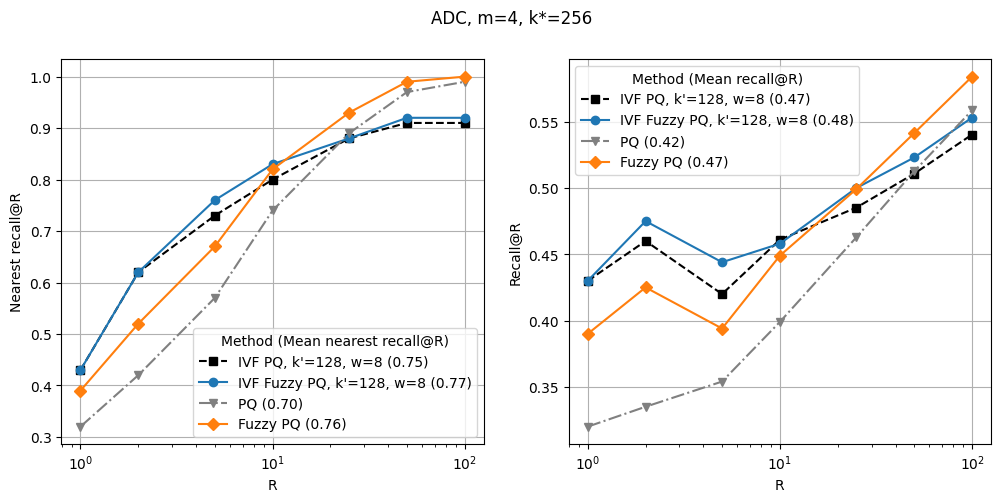

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(R, results_ivf["nearest_recall_mean"], '--s', label=f"IVF PQ, k'={KP}, w={W} ({np.nanmean(results_ivf['nearest_recall_mean']):.2f})", color="black")
axs[0].plot(R, results_fivf["nearest_recall_mean"], '-o', label=f"IVF Fuzzy PQ, k'={KP}, w={W} ({np.nanmean(results_fivf['nearest_recall_mean']):.2f})")
axs[0].plot(R, results_fpq[None]["nearest_recall_mean"], '-.v', label=f"PQ ({np.nanmean(results_fpq[None]['nearest_recall_mean']):.2f})", color="gray")
axs[0].plot(R, results_fpq[fuzzifier]["nearest_recall_mean"], '-D', label=f"Fuzzy PQ ({np.nanmean(results_fpq[fuzzifier]['nearest_recall_mean']):.2f})")
axs[0].set_xscale('log')
axs[0].set_xlabel('R')
axs[0].set_ylabel('Nearest recall@R')
axs[0].legend(title='Method (Mean nearest recall@R)')
axs[0].grid()

axs[1].plot(R, results_ivf["recall_mean"], '--s', label=f"IVF PQ, k'={KP}, w={W} ({np.nanmean(results_ivf['recall_mean']):.2f})", color="black")
axs[1].plot(R, results_fivf["recall_mean"], '-o', label=f"IVF Fuzzy PQ, k'={KP}, w={W} ({np.nanmean(results_fivf['recall_mean']):.2f})")
axs[1].plot(R, results_fpq[None]["recall_mean"], '-.v', label=f"PQ ({np.nanmean(results_fpq[None]['recall_mean']):.2f})", color="gray")
axs[1].plot(R, results_fpq[fuzzifier]["recall_mean"], '-D', label=f"Fuzzy PQ ({np.nanmean(results_fpq[fuzzifier]['recall_mean']):.2f})")
axs[1].set_xscale('log')
axs[1].set_xlabel('R')
axs[1].set_ylabel('Recall@R')
axs[1].legend(title='Method (Mean recall@R)')
axs[1].grid()

fig.suptitle(f"ADC, m={M}, k*={K}");